In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50 #This is something to iterate

In [3]:
## First we are going to load all of data into a tf.data.Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory('PlantVillage',
                                                   shuffle = True,
                                                   image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
#We have a len of 68 because we batched all of the images into sizes of 32. Now 2152/32 is 67.25 so one of our batches is 
#is short but that won't matter for training because the neural network can still learn weights from a partial batch because it 
# is the same set of weights operating on all of the images in the batch.

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 1 0 0 1 0 1 2 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1]


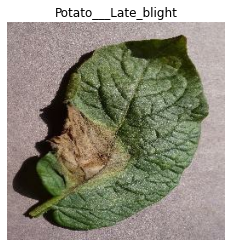

In [8]:
import matplotlib.pyplot as plt

for image_batch, label_batch in dataset.take(1):
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_names[label_batch[0]])
        plt.axis('off')

In [9]:
#Let's split the dataset. We will have a training set of 80%, a val of 10% and a test of 10%.
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
# now we have 68-54=14 left, so val and test will each get 7 
the_rest = dataset.skip(54)

val_ds = the_rest.take(7)
train_ds = the_rest.skip(7)

In [11]:
len(val_ds)

7

In [12]:
len(train_ds)

7

In [13]:
#Let's write a nice function that can do this for us so we don't have to do it by hand.
def dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=89)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    test_size = int(ds_size*test_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
## We don't want to have to fetch the images from memory everytime we need them for training so we are going to cache them in RAM
##We will also prefetch because while the CNN is training on GPU, we don't want the cpu to idle so we will maximize time use by prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
##We are now going to do some image preprocessing using ImageDataGenerator. One of the most common techniques is normalizing
## the pixel values from 0-255 to 0-1 and we will do that by multiplying each pixel value by 1/255.
## Normalizing is helpful here because since each value is between 0-1 and activation functions operate at that range,
## it means it means computation of gradiants will less frequently be non-zero so learning is faster 

In [20]:
resize_and_rescale = Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
model = Sequential([
    resize_and_rescale,
    data_augmentation,
    Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 16, kernel_size=(3,3), activation= 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 8, kernel_size=(3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    Dense(3, activation = 'softmax')
])

In [23]:
model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [24]:
model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 16)         0         
 2D)                                                  

In [25]:
history = model.fit(train_ds, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1, validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 21s 174ms/step - loss: 0.7023 - accuracy: 0.7049 - val_loss: 0.4162 - val_accuracy: 0.8438
Epoch 2/50
54/54 [==============================] - 6s 113ms/step - loss: 0.4375 - accuracy: 0.8397 - val_loss: 0.4570 - val_accuracy: 0.8177
Epoch 3/50
54/54 [==============================] - 6s 105ms/step - loss: 0.4216 - accuracy: 0.8426 - val_loss: 0.3810 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 6s 103ms/step - loss: 0.3456 - accuracy: 0.8553 - val_loss: 0.3497 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 6s 103ms/step - loss: 0.3790 - accuracy: 0.8495 - val_loss: 0.3930 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 6s 102ms/step - loss: 0.3202 - accuracy: 0.8785 - val_loss: 0.4239 - val_accuracy: 0.8073
Epoch 7/50
54/54 [==============================] - 6s 102ms/step - loss: 0.2808 - accuracy: 0.8912 - val_loss: 0.4000 - val_accuracy: 0.8125
Epoch

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 31ms/step - loss: 0.0372 - accuracy: 0.9914


In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

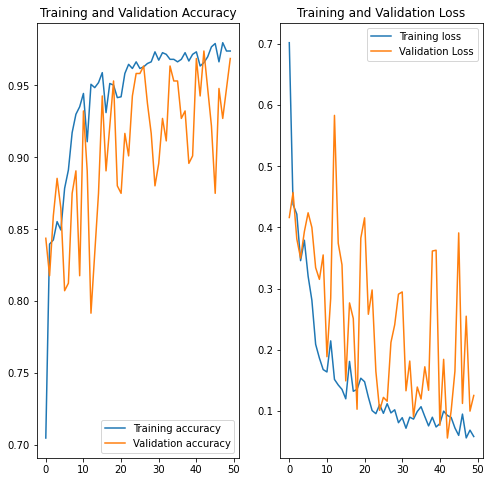

In [45]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [46]:
import numpy as np

1/1 [==============================] - 0s 31ms/step


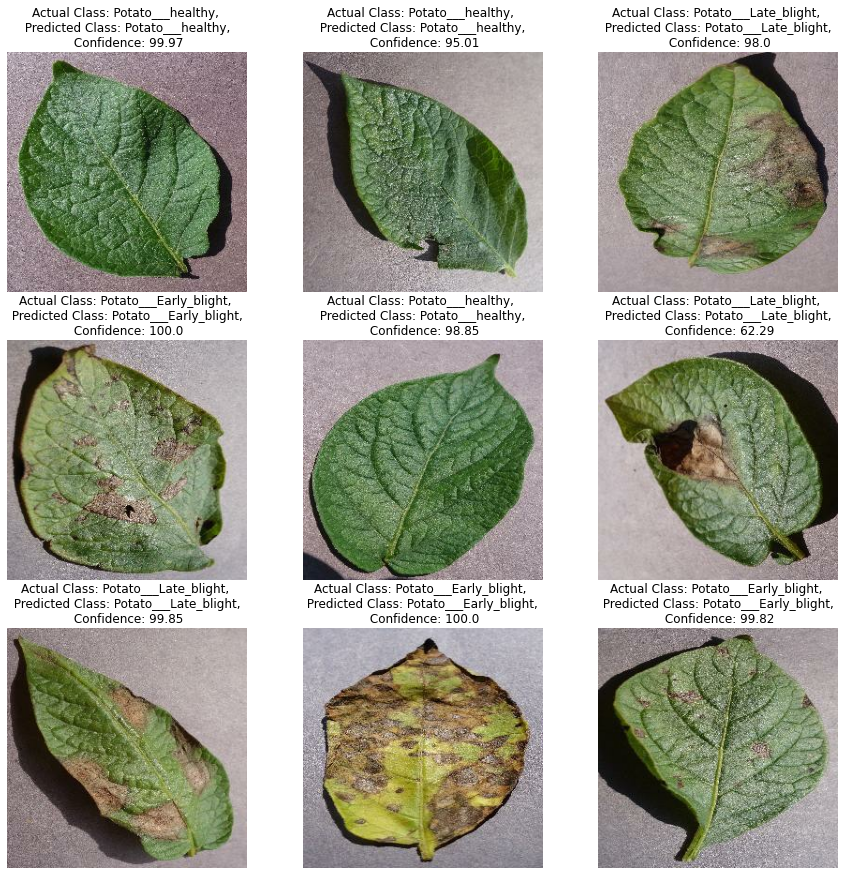

In [66]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    batch_prediction = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        confidence = round(100*np.max(batch_prediction[i]), 2)
        actual_class = class_names[labels[i]]
        Predicted_class = class_names[np.argmax(batch_prediction[i])]
        
        plt.title(f"Actual Class: {actual_class}, \n Predicted Class: {Predicted_class}, \n Confidence: {confidence}")
        plt.axis('off')

In [67]:
model_version = 1
model.save(f"potato_disease_identifier{model_version}")

INFO:tensorflow:Assets written to: potato_disease_identifier1\assets


INFO:tensorflow:Assets written to: potato_disease_identifier1\assets
